<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/01b_model_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [10]:
!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [11]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Model API

This tutorial introduces the SeisBench model API. It explains how to load pretrained models and apply them to generate characteristic curves or discrete picks.

**Note:** Some familiarity with obspy is helpful for this tutorial, but not required.

In [12]:
import seisbench
import seisbench.models as sbm

### Creating a model

SeisBench models are built in pytorch. They can simply be created by intiatiating an object of the desired class.
Let's first create a simple PhaseNet model. As we see in the output, the model consists of a down branch and an up branch, both comprised of (transposed) convolutional layers. Furthermore, the model indicates that it expects data with ZNE component order

In [ ]:
model = sbm.PhaseNet()
print(model)

Component order:	ZNE
SeisBench model		PhaseNet

PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      

As pytorch model, the model can be applied to pytorch tensors. The output for PhaseNet are probabilities for P arrivals, S arrivals and noise for every sample.

In [ ]:
import torch

x = torch.rand(1, 3, 3001)  # 1 example, 3 components, 3001 samples
model.eval()
with torch.no_grad():
    print(model(x))

tensor([[[0.2751, 0.2785, 0.2764,  ..., 0.2719, 0.2668, 0.2662],
         [0.3832, 0.3834, 0.3850,  ..., 0.3897, 0.3939, 0.3903],
         [0.3417, 0.3381, 0.3386,  ..., 0.3384, 0.3393, 0.3435]]])


### Loading pretrained models

The model created above consisted of random weights, i.e., it was not trained. While this is (often) the right approach when starting to train a model, for application we'll need a trained model. SeisBench offers pretrained models, which can be loaded with the `from_pretrained` method. To list available pretrained models, we can use `list_pretrained`. By setting `details=True`, we also get a docstring for each model.

In [13]:
pretrained_weights = sbm.PhaseNet.list_pretrained(details=True)
for key, value in pretrained_weights.items():
    print(f"{key}:\n{value}\n-----------------------\n")

diting:
Model trained on the DiTing dataset, a large-scale Chinese seismic benchmark dataset.
For models fine-tuned on individual regions in China, please see: https://github.com/JUNZHU-SEIS/USTC-Pickers
If you use this model, please reference: Zhu J, Li ZF and Fang LH (2023). USTC-Pickers: a Unified Set of seismic phase pickers Transfer learned for China. Earthq Sci 36(2): 95–112, doi: 10.1016/j.eqs.2023.03.001
-----------------------

ethz:
Model trained on ETHZ for 100 epochs with a learning rate of 0.01.
Threshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need to be adjusted.
When using this model, please reference the SeisBench publications listed at https://github.com/seisbench/seisbench

Jannes Münchmeyer, Jack Woollam (munchmej@gfz-potsdam.de, jack.woollam@kit.edu)
-----------------------

geofon:
Model trained on GEOFON for 100 epochs with a learning rate of 0.001.
Threshold selected for optimal F1 score on in-d

We are going to load the model from Zhu et al. (2018) that was trained on examples from California. If the model is loaded for the first time, it will be downloaded from the SeisBench repository. The downloaded model is cached in the SeisBench cache. Pretrained models also have docstrings, describing the model.

In [68]:
model = sbm.PhaseNet.from_pretrained("original")
print(model.weights_docstring)

Original PhaseNet model from Zhu et al. (2018). Originally published under MIT License. Original available at https://github.com/AI4EPS/PhaseNet/tree/master/model/190703-214543 . 

Converted to SeisBench by Jannes Münchmeyer (munchmej@univ-grenoble-alpes.fr) with help from Sacha Lapins, Yiyuan Zhong, and Jun Zhu


### Annotating waveform streams

SeisBench models can directly annotate obspy streams. Let's download a 200 s long piece of waveforms from a station in Chile through FDSN and visualize it.

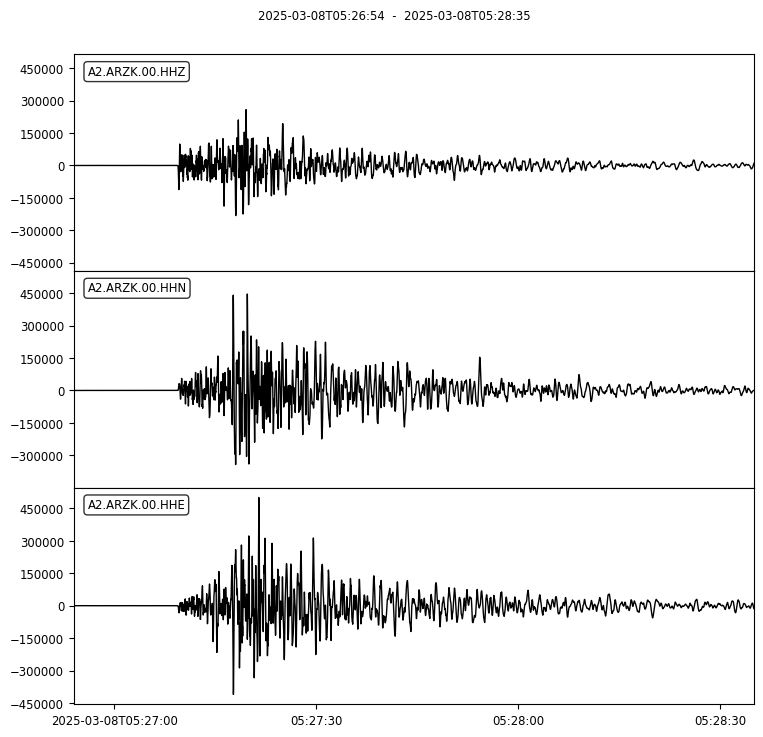

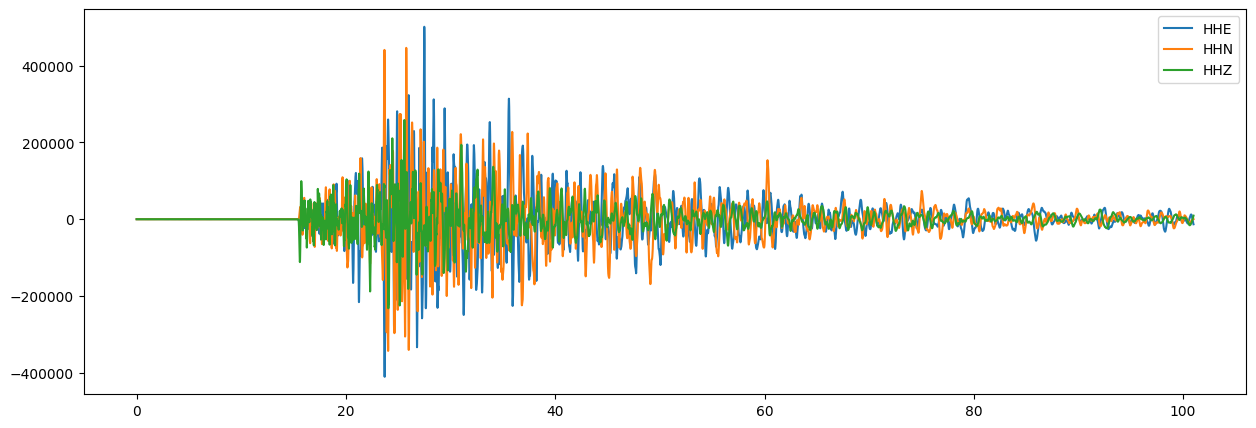

In [124]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt

client = Client("IRIS")

start_time = UTCDateTime("2025-03-08T05:26:55")
# end_time   = UTCDateTime("2024-12-20T23:02:29.99000Z")

# t = UTCDateTime("2007/01/02 05:48:50")
stream = client.get_waveforms(network="A2", station="ARZK", location="*", channel="HH?", starttime=start_time-1, endtime=start_time+100)

stream.plot()

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()

SeisBench models can generate characteristic curves, i.e., curves providing the probability of a pick at a certain time. For this, the annotate function is used. Annotate automatically transforms the trace into a compatible format for the model and merges the preditions into traces. For example, annotate will determine the correct component order and resample the trace to the required sampling rate.

In [125]:
annotations = model.annotate(stream)
print(annotations)

3 Trace(s) in Stream:
A2.ARZK.00.EQTransformer_Detection | 2025-03-08T05:26:59.000000Z - 2025-03-08T05:28:30.000000Z | 100.0 Hz, 9101 samples
A2.ARZK.00.EQTransformer_P         | 2025-03-08T05:26:59.000000Z - 2025-03-08T05:28:30.000000Z | 100.0 Hz, 9101 samples
A2.ARZK.00.EQTransformer_S         | 2025-03-08T05:26:59.000000Z - 2025-03-08T05:28:30.000000Z | 100.0 Hz, 9101 samples


`annotate` takes additional, optional arguments that depend on the specific model and are documented in the model defintion. For example, PhaseNet is applied with a sliding window approach and therefore has a `overlap` parameter, indicating the overlap in samples between two consequtive applications of the model. Let's try out a different overlap.

In [126]:
annotations = model.annotate(stream, overlap=2000)
print(annotations)

3 Trace(s) in Stream:
A2.ARZK.00.EQTransformer_Detection | 2025-03-08T05:26:59.000000Z - 2025-03-08T05:28:30.000000Z | 100.0 Hz, 9101 samples
A2.ARZK.00.EQTransformer_P         | 2025-03-08T05:26:59.000000Z - 2025-03-08T05:28:30.000000Z | 100.0 Hz, 9101 samples
A2.ARZK.00.EQTransformer_S         | 2025-03-08T05:26:59.000000Z - 2025-03-08T05:28:30.000000Z | 100.0 Hz, 9101 samples


You might have also noticed that the annotation process took a bit longer, because PhaseNet was applied more often than with the default overlap.

Let's visualize the predictions alongside the waveforms. As we can see, PhaseNet correctly identified the P and S arrival of the main event. Note that the confidence values (the peaks of the probability curves) are high, but not quite 1. This is common for deep learning based picking models.

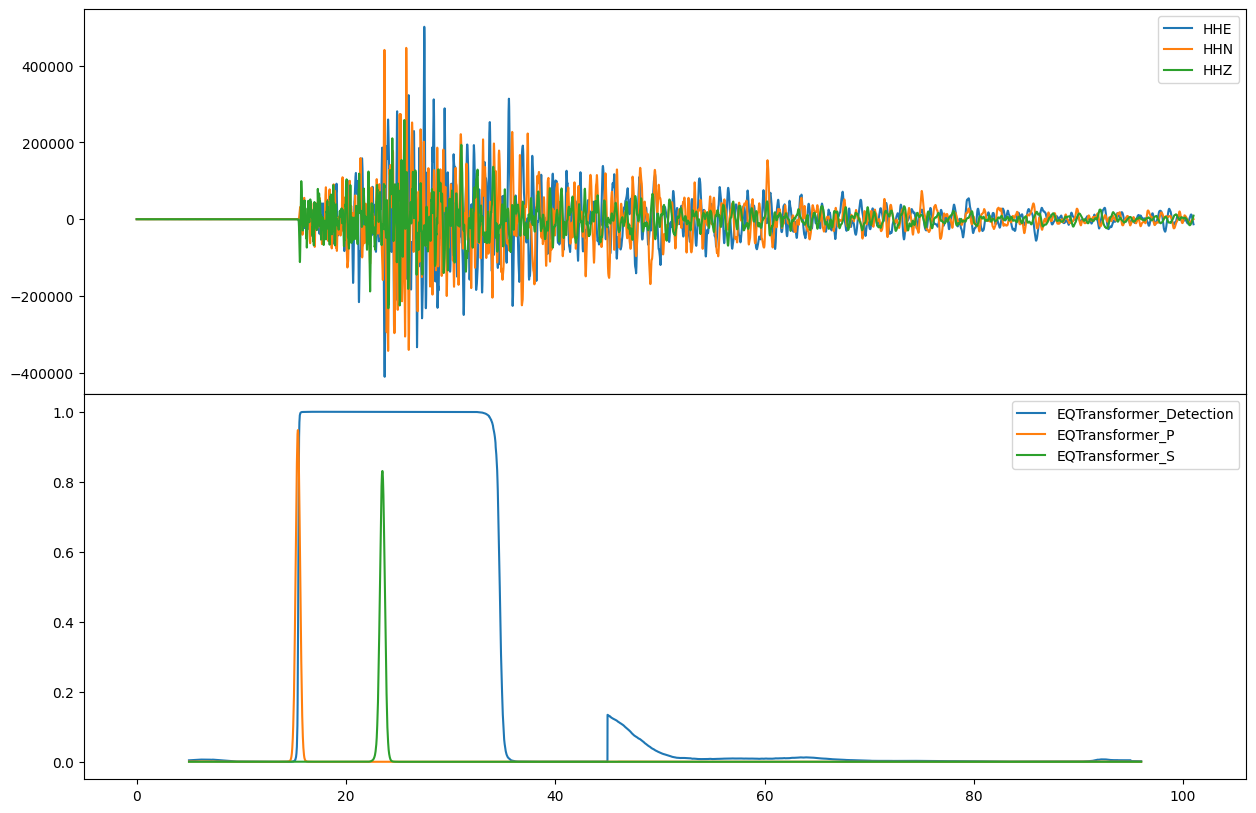

In [127]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In addition to the `annotate` function, SeisBench models offer the `classify` function. This function returns discrete objects, in this case, picks. Again, we can pass configuration parameters to the function. Here, we provide detection thresholds. Let's first print all outputs together.

In [128]:
output = model.classify(stream, P_threshold=0.5, S_threshold=0.5)
print(output)

ClassifyOutput(creator='EQTransformer', picks=PickList with 2 entries:

A2.ARZK.00	2025-03-08T05:27:09.400000Z	P
A2.ARZK.00	2025-03-08T05:27:17.490000Z	S, detections=DetectionList with 1 entries:

A2.ARZK.00	2025-03-08T05:27:09.480000Z	2025-03-08T05:27:28.770000Z)


Alternatively, we can access the picks separately. The picks are a simple list that can be iterated over or access through indexing.

In [129]:
print(output.picks)

PickList with 2 entries:

A2.ARZK.00	2025-03-08T05:27:09.400000Z	P
A2.ARZK.00	2025-03-08T05:27:17.490000Z	S


### Model interchangability

The standardized model API makes it easy to use a different model. Let's try out EQTransformer. For this, we use the weights trained on the STEAD dataset (Mousavi et al. 2019, Münchmeyer et al. 2022). Note that in addition to picks, EQTransformer returns detections.

In [110]:
model = sbm.EQTransformer.from_pretrained("stead")
print(model.weights_docstring)

Model trained on STEAD for 100 epochs with a learning rate of 0.001.
Threshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need to be adjusted.
When using this model, please reference the SeisBench publications listed at https://github.com/seisbench/seisbench

Jannes Münchmeyer, Jack Woollam (munchmej@gfz-potsdam.de, jack.woollam@kit.edu)


3 Trace(s) in Stream:
A2.ARZK.00.EQTransformer_Detection | 2025-03-08T05:26:59.000000Z - 2025-03-08T05:28:30.000000Z | 100.0 Hz, 9101 samples
A2.ARZK.00.EQTransformer_P         | 2025-03-08T05:26:59.000000Z - 2025-03-08T05:28:30.000000Z | 100.0 Hz, 9101 samples
A2.ARZK.00.EQTransformer_S         | 2025-03-08T05:26:59.000000Z - 2025-03-08T05:28:30.000000Z | 100.0 Hz, 9101 samples


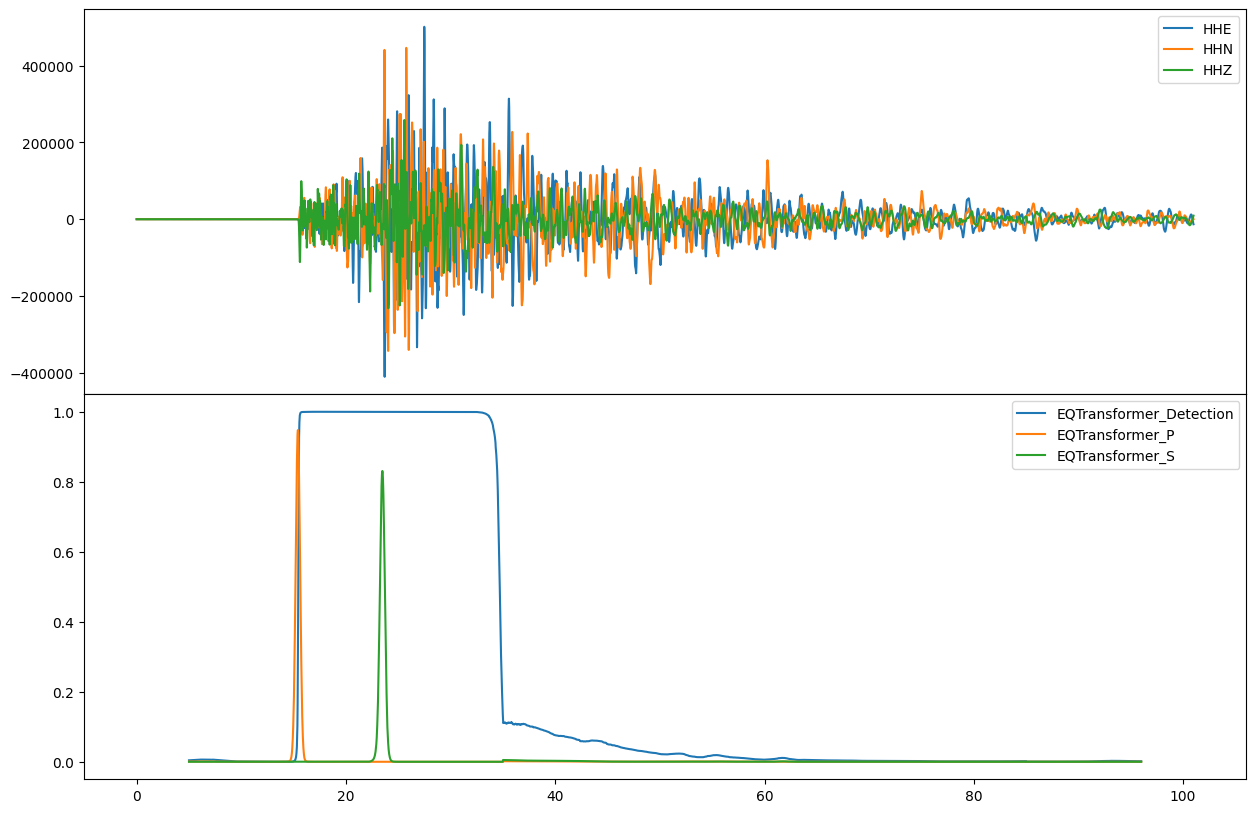

In [130]:
annotations = model.annotate(stream)
print(annotations)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In [131]:
output = model.classify(stream)
print(output)

ClassifyOutput(creator='EQTransformer', picks=PickList with 2 entries:

A2.ARZK.00	2025-03-08T05:27:09.400000Z	P
A2.ARZK.00	2025-03-08T05:27:17.490000Z	S, detections=DetectionList with 1 entries:

A2.ARZK.00	2025-03-08T05:27:09.480000Z	2025-03-08T05:27:28.770000Z)


In [132]:
p_pick = output.picks[0].peak_time
s_pick = output.picks[1].peak_time
# for i in output.picks:
#   print(i.)
print(p_pick)

2025-03-08T05:27:09.400000Z


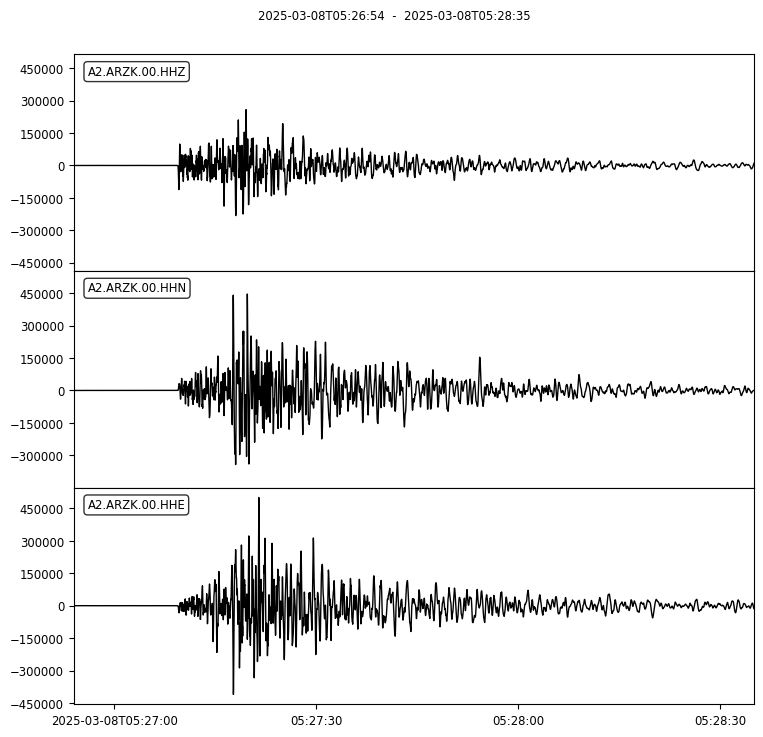

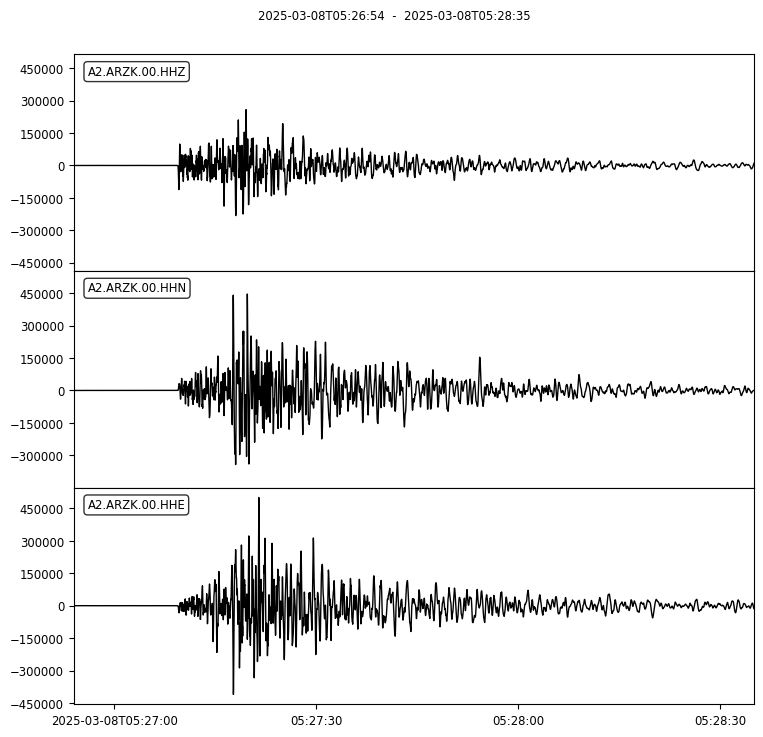

In [133]:
picks = [
    {"time": p_pick, "label": "P", "color": "red"},
    {"time": s_pick, "label": "S", "color": "blue"}
]

# Plot with picks
stream.plot(events=picks)

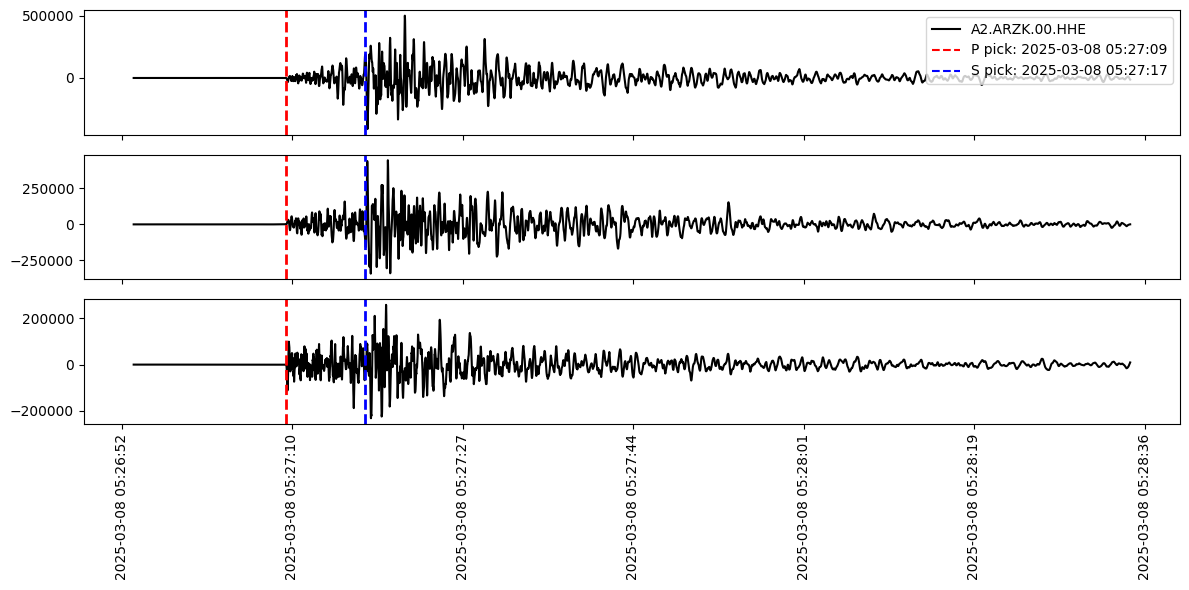

In [134]:
import matplotlib.dates as mdates
st = stream
fig, axes = plt.subplots(len(stream), 1, figsize=(12, 6), sharex=True)

if len(stream) == 1:
    axes = [axes]

for i, tr in enumerate(stream):
    times = tr.times("matplotlib")
    axes[i].plot(times, tr.data, label=tr.id, color="black")

    # Add pick lines
    axes[i].axvline(p_pick.matplotlib_date, color="red", linestyle="--", linewidth=2)
    axes[i].axvline(s_pick.matplotlib_date, color="blue", linestyle="--", linewidth=2)

    # Add pick info in legend only on the first subplot
    if i == 0:
        axes[i].plot([], [], color="red", linestyle="--", label=f"P pick: {p_pick.strftime('%Y-%m-%d %H:%M:%S')}")
        axes[i].plot([], [], color="blue", linestyle="--", label=f"S pick: {s_pick.strftime('%Y-%m-%d %H:%M:%S')}")
        axes[i].legend(loc="upper right")

# Format x-axis
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))

# Rotate x-axis labels
for label in axes[-1].get_xticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment("center")

plt.tight_layout()
plt.show()

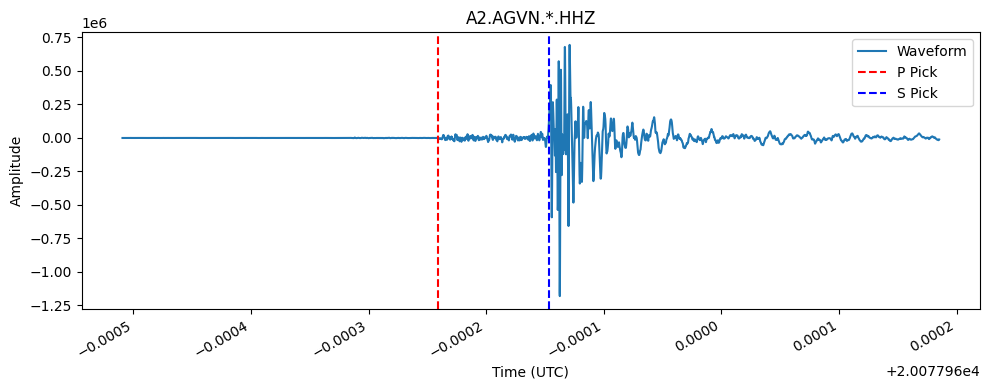

In [ ]:
tr = stream[0]
fig, ax = plt.subplots(figsize=(10, 4))
times = tr.times("matplotlib")
network = 'A2'
station = 'AGVN'
location = '*'
channel = 'HHZ'
ax.plot(times, tr.data, label="Waveform")
ax.axvline(p_pick.matplotlib_date, color='r', linestyle='--', label="P Pick")
ax.axvline(s_pick.matplotlib_date, color='b', linestyle='--', label="S Pick")
ax.legend()
ax.set_title(f"{network}.{station}.{location}.{channel}")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Amplitude")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

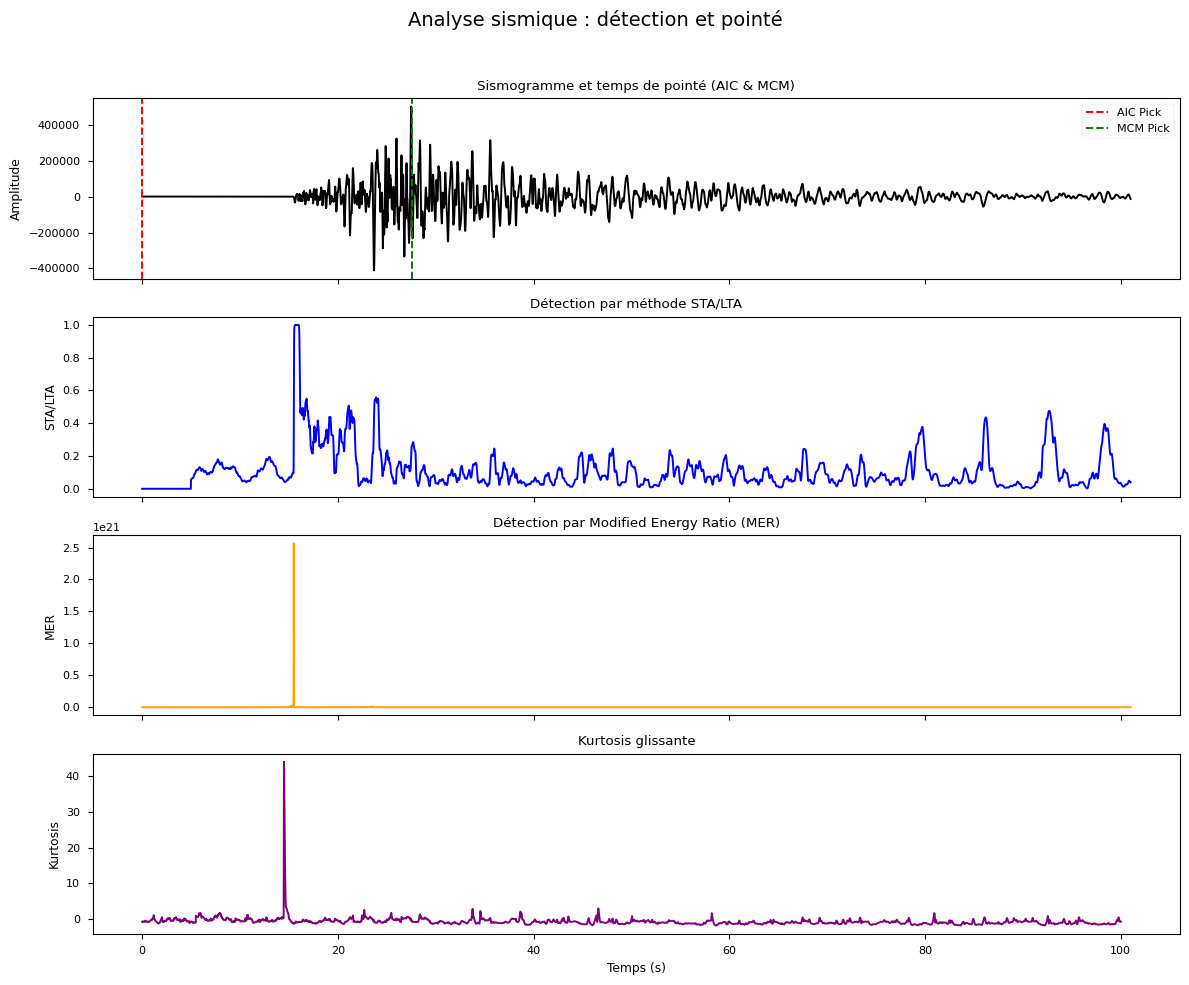

In [135]:
import numpy as np
from scipy.stats import kurtosis
from scipy.signal import correlate
tr = st[0]
data = tr.data.astype(float)
sampling_rate = tr.stats.sampling_rate
npts = tr.stats.npts
times = np.arange(npts) / sampling_rate

# Fonctions déjà définies
def sta_lta(signal, nsta, nlta):
    sta = np.cumsum(signal ** 2)
    sta[nsta:] -= sta[:-nsta]
    lta = np.cumsum(signal ** 2)
    lta[nlta:] -= lta[:-nlta]
    sta = sta[nlta - 1:]
    lta = lta[nlta - 1:]
    return np.pad(sta / (lta + 1e-10), (nlta - 1, 0), mode='constant')

def mer(signal, L):
    energy_ratio = np.array([
        np.sum(signal[i:i+L]**2) / (np.sum(signal[i-L:i]**2) + 1e-10)
        for i in range(L, len(signal)-L)
    ])
    return np.pad((energy_ratio * np.abs(signal[L:-L])) ** 3, (L, L), mode='constant')

def aic_pick(signal):
    N = len(signal)
    aic_vals = np.zeros(N)
    for k in range(1, N-1):
        var1 = np.var(signal[:k]) + 1e-10
        var2 = np.var(signal[k:]) + 1e-10
        aic_vals[k] = k * np.log(var1) + (N - k - 1) * np.log(var2)
    return np.argmin(aic_vals), aic_vals

def mcm(signal):
    return np.argmax(np.abs(np.diff(signal)))

def sliding_kurtosis(signal, window_size):
    return np.array([kurtosis(signal[i:i+window_size])
                     for i in range(len(signal) - window_size)])

# Traitement
sta_lta_res = sta_lta(data, int(0.5*sampling_rate), int(5*sampling_rate))
mer_res = mer(data, int(1*sampling_rate))
aic_pick_index, _ = aic_pick(data)
mcm_pick_index = mcm(data)
kurt_res = sliding_kurtosis(data, int(1*sampling_rate))

# Style de plot pour article
plt.style.use('seaborn-v0_8-paper')
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 1. Sismogramme
axs[0].plot(times, data, color='black')
axs[0].axvline(times[aic_pick_index], color='red', linestyle='--', label='AIC Pick')
axs[0].axvline(times[mcm_pick_index], color='green', linestyle='--', label='MCM Pick')
axs[0].legend()
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Sismogramme et temps de pointé (AIC & MCM)")

# 2. STA/LTA
axs[1].plot(times, sta_lta_res, color='blue')
axs[1].set_ylabel("STA/LTA")
axs[1].set_title("Détection par méthode STA/LTA")

# 3. MER
axs[2].plot(times, mer_res, color='orange')
axs[2].set_ylabel("MER")
axs[2].set_title("Détection par Modified Energy Ratio (MER)")

# 4. Kurtosis
axs[3].plot(times[:len(kurt_res)], kurt_res, color='purple')
axs[3].set_ylabel("Kurtosis")
axs[3].set_title("Kurtosis glissante")

# Ajustement final
axs[-1].set_xlabel("Temps (s)")
fig.suptitle("Analyse sismique : détection et pointé", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("analyse_sismique_resultats.png", dpi=300)
plt.show()

As before, we can access the outputs individually, in this case we now have the `detection` attribute in addition to the `picks`.

In [52]:
print(output.picks)
print(output.detections)

PickList with 1 entries:

IU.GNI.10	2025-03-08T05:27:15.400000Z	P
DetectionList with 1 entries:

IU.GNI.10	2025-03-08T05:27:15.500000Z	2025-03-08T05:27:48.540000Z


### Batch processing

Processing is not limited to a single station, but can be applied to streams from different stations. SeisBench will automatically convert the traces into the correct tensors and the annotations back to streams. For more efficient processing, let's first move the model to GPU. Moving a model to GPU will automatically process the computations of `annotate` and `classify` on GPU.

**Note:** In Colab, to use GPU you need to select a GPU runtime environment.

In [26]:
import torch
if torch.cuda.is_available():
    model.cuda()
    print("Running on GPU")
else:
    print("NOT running on GPU")

NOT running on GPU


Now let's download the same time window as above, but for all stations in the CX network and generate the picks and detections with EQTransformer.

In [103]:
stream = client.get_waveforms(network="A2", station="*", location="*", channel="HH?", starttime=start_time-100, endtime=start_time+100)

output = model.classify(stream)
print(output.picks)
print(output.detections)

PickList with 11 entries:

A2.ARZK.00	2025-03-08T05:27:09.460000Z	P
A2.ARZK.00	2025-03-08T05:27:17.470000Z	S
A2.KCHK.00	2025-03-08T05:27:26.670000Z	P
...
A2.TTJR.00	2025-03-08T05:27:15.750000Z	P
A2.TTJR.00	2025-03-08T05:27:28.110000Z	S
A2.ZRSH.00	2025-03-08T05:27:07.640000Z	P
DetectionList with 10 entries:

A2.ZRSH.00	2025-03-08T05:26:20.000000Z	2025-03-08T05:26:23.720000Z
A2.SVZR.00	2025-03-08T05:26:50.000000Z	2025-03-08T05:27:07.190000Z
A2.SHMT.00	2025-03-08T05:27:06.970000Z	2025-03-08T05:27:21.920000Z
A2.ZRSH.00	2025-03-08T05:27:07.700000Z	2025-03-08T05:27:24.240000Z
A2.ARZK.00	2025-03-08T05:27:09.470000Z	2025-03-08T05:27:28.770000Z
A2.LRNG.00	2025-03-08T05:27:12.700000Z	2025-03-08T05:27:36.140000Z
A2.TTJR.00	2025-03-08T05:27:15.850000Z	2025-03-08T05:27:45.270000Z
A2.SVZR.00	2025-03-08T05:27:23.620000Z	2025-03-08T05:28:09.990000Z
A2.KCHK.00	2025-03-08T05:27:26.760000Z	2025-03-08T05:28:09.990000Z
A2.AGVN.00	2025-03-08T05:27:38.580000Z	2025-03-08T05:28:30.000000Z


This concludes the model API tutorial. Check out the other SeisBench tutorials to get to know the other functionalities.

In [136]:
model = sbm.DeepDenoiser.from_pretrained("original")

In [137]:
stream_1 = model.annotate(stream)

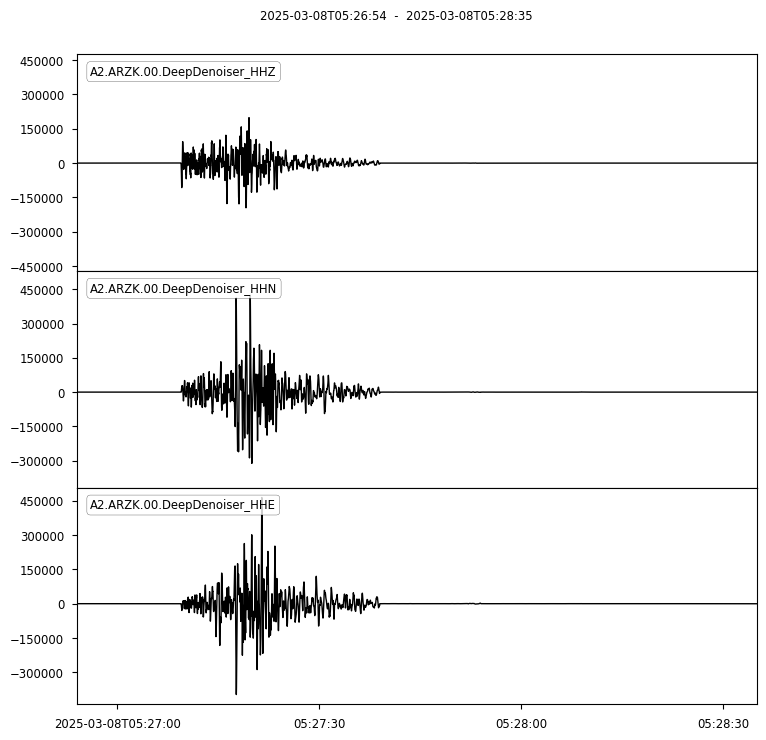

In [138]:
stream_1.plot();

Original PhaseNet model from Zhu et al. (2018). Originally published under MIT License. Original available at https://github.com/AI4EPS/PhaseNet/tree/master/model/190703-214543 . 

Converted to SeisBench by Jannes Münchmeyer (munchmej@univ-grenoble-alpes.fr) with help from Sacha Lapins, Yiyuan Zhong, and Jun Zhu
3 Trace(s) in Stream:
A2.ARZK.00.PhaseNet_N | 2025-03-08T05:26:56.500000Z - 2025-03-08T05:28:32.500000Z | 100.0 Hz, 9601 samples
A2.ARZK.00.PhaseNet_P | 2025-03-08T05:26:56.500000Z - 2025-03-08T05:28:32.500000Z | 100.0 Hz, 9601 samples
A2.ARZK.00.PhaseNet_S | 2025-03-08T05:26:56.500000Z - 2025-03-08T05:28:32.500000Z | 100.0 Hz, 9601 samples
ClassifyOutput(creator='PhaseNet', picks=PickList with 2 entries:

A2.ARZK.00	2025-03-08T05:27:09.500000Z	P
A2.ARZK.00	2025-03-08T05:27:17.520000Z	S)
Model trained on STEAD for 100 epochs with a learning rate of 0.001.
Threshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need t

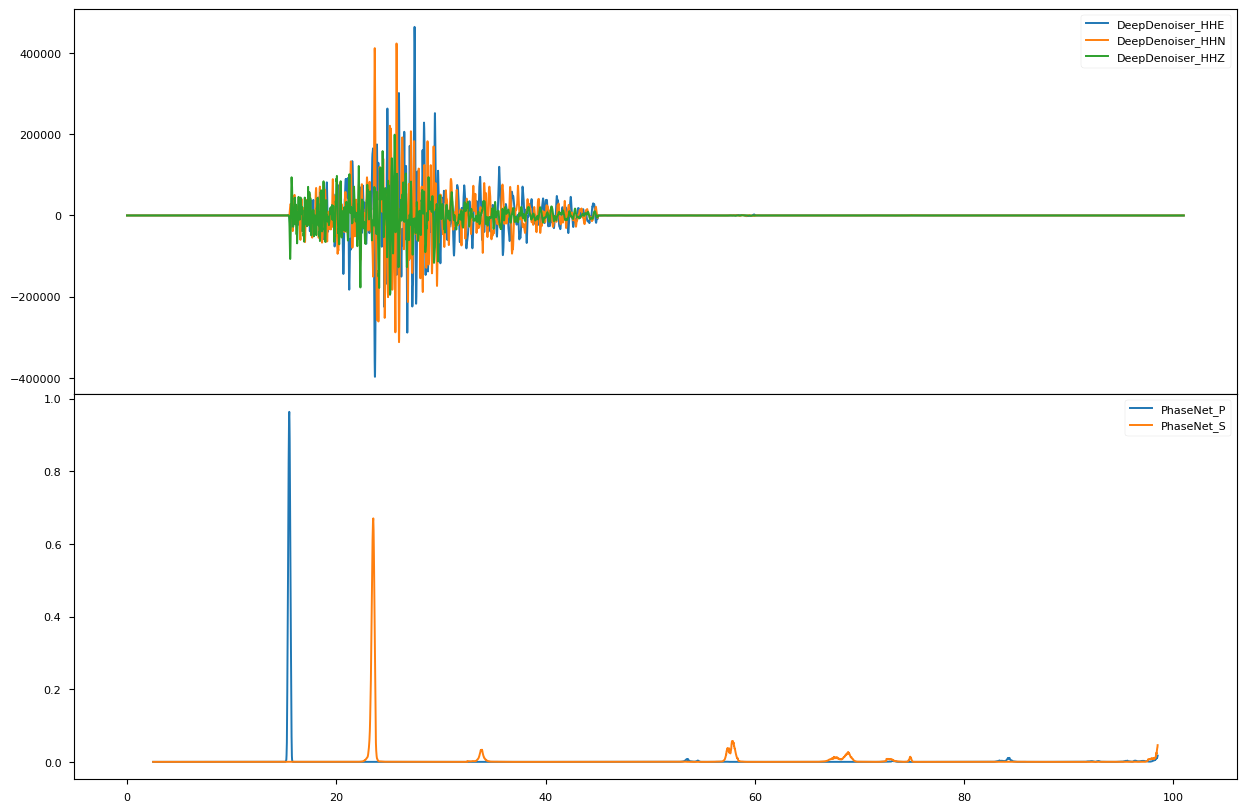

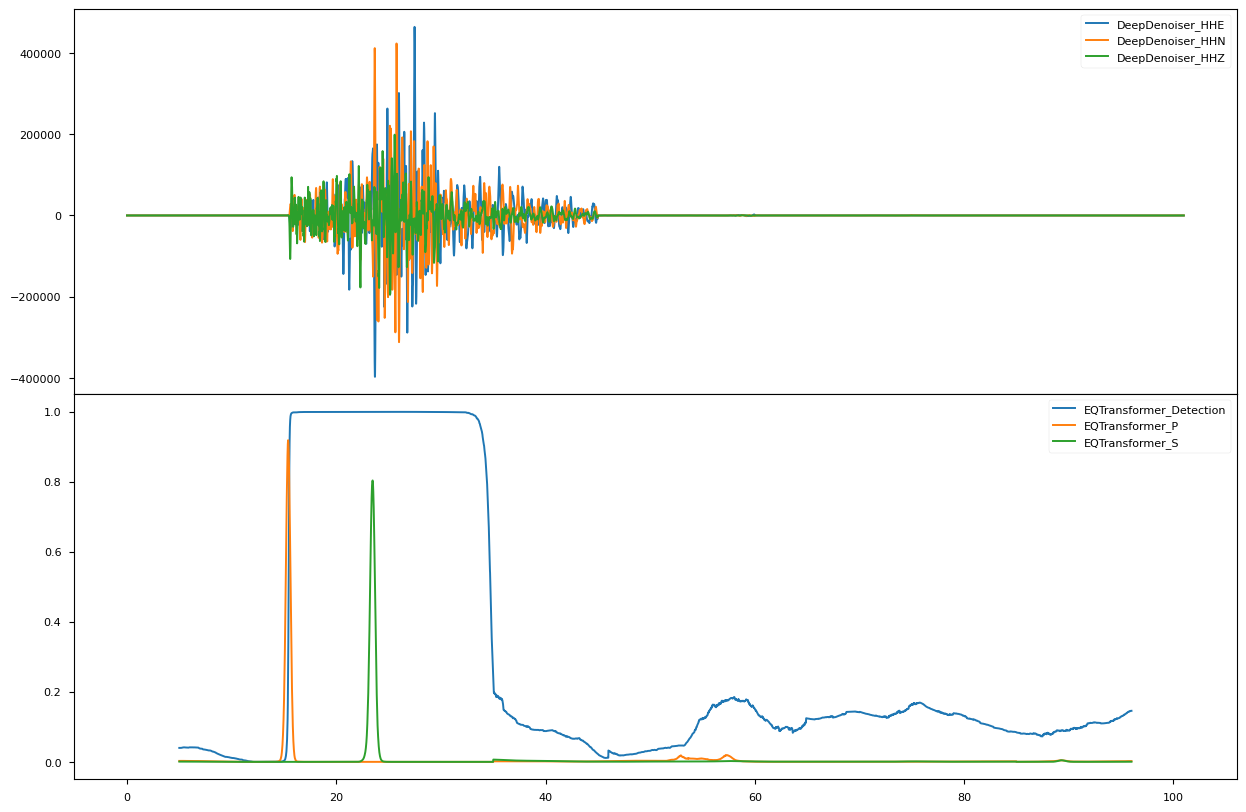

In [139]:
model = sbm.PhaseNet.from_pretrained("original")
print(model.weights_docstring)
annotations = model.annotate(stream_1, overlap=2000)
print(annotations)
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream_1[i].times(), stream_1[i].data, label=stream_1[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()
output = model.classify(stream_1, P_threshold=0.5, S_threshold=0.5)
print(output)

model = sbm.EQTransformer.from_pretrained("stead")
print(model.weights_docstring)

annotations = model.annotate(stream_1)
print(annotations)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream_1[0].stats.starttime
for i in range(3):
    axs[0].plot(stream_1[i].times(), stream_1[i].data, label=stream_1[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

output = model.classify(stream_1)
print(output)

In [140]:
picker = sbm.EQTransformer.from_pretrained("instance")

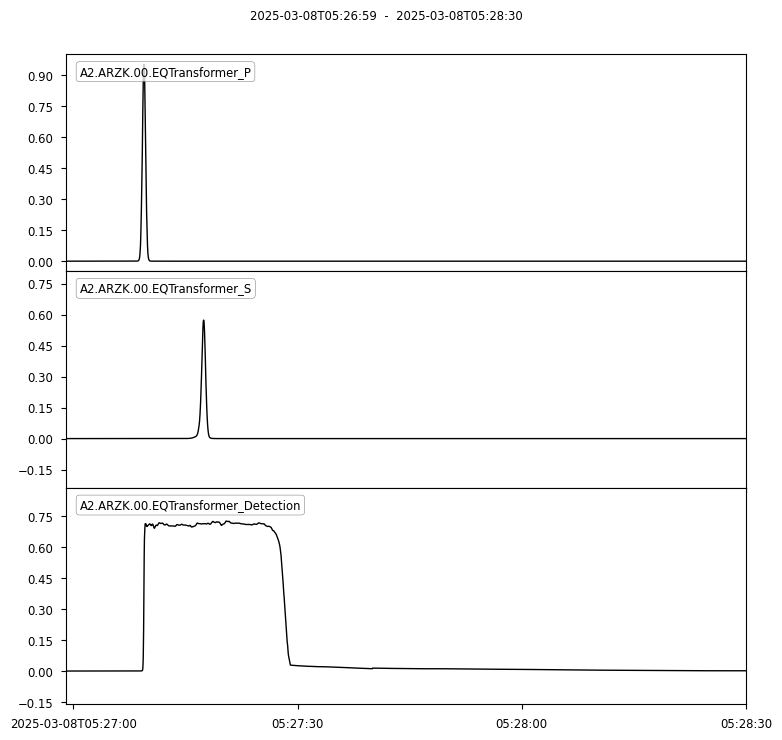

In [141]:
picker.annotate(stream).plot();

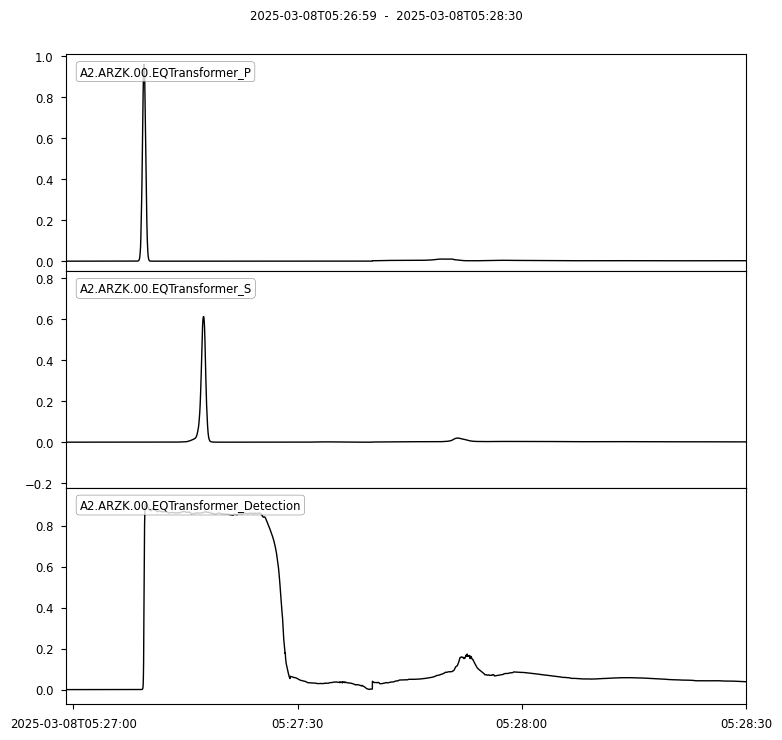

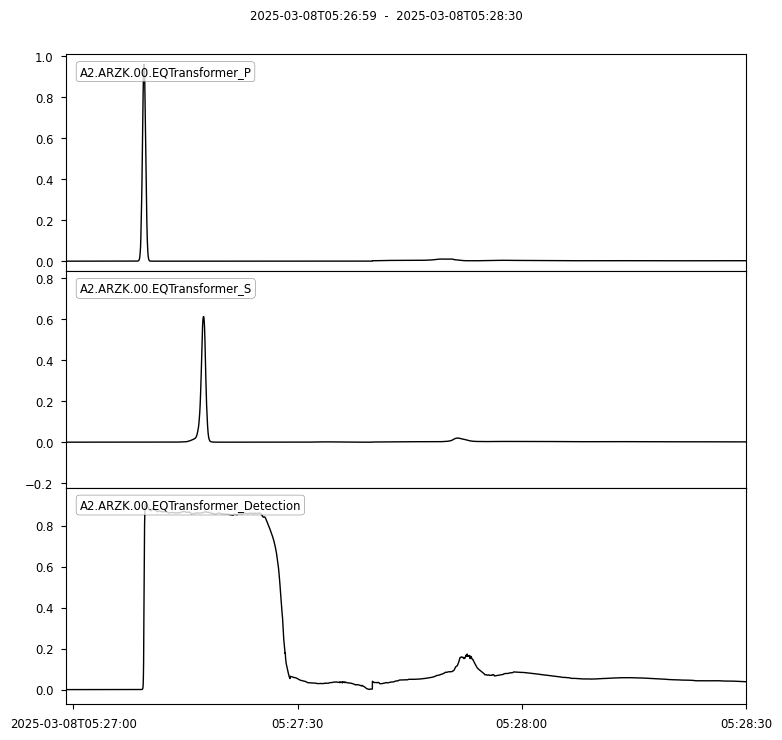

In [142]:
picker.annotate(stream_1).plot()